# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares? ¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**
***
***
### 0. descargamos la librerías que utilizaremos ###


In [1]:
import gzip
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="Blues_d")


def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## **Reviews** ##

Se descargan los datos de las reviews y se los pasara a un archivo .csv debido a que el proceso de descarga demora un tiempo considerable. 

In [2]:
# %%time
# contador = 0
# data_reviews = []
# # Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# # abrira uno de cada tres, y asi.
# n = 1
# for l in parse('steam_reviews.json.gz'):
#     if contador%n == 0:
#         data_reviews.append(l)
#     else:
#         pass
#     contador += 1
# data_reviews = pd.DataFrame(data_reviews)

# data_reviews.to_csv('data_reviews.csv',index=False)


data_reviews = pd.read_csv('data_reviews.csv')

In [3]:
print(f'Nº de filas: {data_reviews.shape[0]}')
print(f'Nº de columnas: {data_reviews.shape[1]}')
print('\n')

print('Nombre de las columnas: ')
for col in data_reviews.columns:
    print(col)

print('\n')


Nº de filas: 7793069
Nº de columnas: 12


Nombre de las columnas: 
username
hours
products
product_id
page_order
date
text
early_access
page
found_funny
compensation
user_id




## **Games** ##

Se descargarán los datos de los juegos y se lo pasara a un archivo .csv para facilitar el posterior acceso.

In [4]:
# %%time
# data_games = []
# for l in parse('steam_games.json.gz'):
#     data_games.append(l)
# data_games = pd.DataFrame(data_games)
# data_games.to_csv('data_games.csv',index=False)

data_games = pd.read_csv('data_games.csv')

In [5]:
print(f'Nº de filas: {data_games.shape[0]}')
print(f'Nº de columnas: {data_games.shape[1]}')
print('\n')

print('Nombre de las columnas: ')
for col in data_games.columns:
    print(col)

print('\n')


Nº de filas: 32135
Nº de columnas: 16


Nombre de las columnas: 
publisher
genres
app_name
title
url
release_date
tags
discount_price
reviews_url
specs
price
early_access
id
developer
sentiment
metascore




***
### 1. Análisis exploratorio ###

Para el modelo de recomendación de filtro colaborativo se utilizara únicamente los datos de reviews.

In [6]:
data_reviews.head()

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,7.656120e+16


In [7]:
data_reviews.isna().sum()

username            208
hours             26537
products          14961
product_id            0
page_order            0
date                  0
text              17972
early_access          0
page                  0
found_funny     6592313
compensation    7647446
user_id         4616846
dtype: int64

Se descartaran las columnas `products`,`page_order`,`date`, `early_acces`,`page`,`found_funny` y `compensation` debido a que no contienen información relevante. `user_id` debido a que hay tantos valores vacíos se descartara y se utilizara `username` para referenciar a los usuarios y `text` si bien es la columna que contiene la información sobre la opinión del usuario hacia el juego pero debido a que es texto supera el alcance de este proyecto.

In [8]:
dr = data_reviews[['username','product_id','hours']].copy()

Se incorpora el título del juego para visualizar mejor.

In [9]:
data_games.rename(columns={'id':'product_id'},inplace=True)
dr = dr.merge(data_games[['product_id','title']],on='product_id')

In [10]:
dr.isna().sum()

username        208
product_id        0
hours         26537
title             0
dtype: int64

Los datos vacíos de `username` y `hours` serán descartados, debido a que son un muy pequeño porcentaje a la totalidad de los datos.

In [11]:
dr.dropna(inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,Chaos Syren,725280,0.1,Psi Project
1,Teef 🐏,725280,0.9,Psi Project
2,nd,725280,1.0,Psi Project
3,Sneaky_Panda,725280,0.6,Psi Project
4,wasp99rock,725280,0.3,Psi Project
...,...,...,...,...
7772790,Joish,518790,13.9,theHunter: Call of the Wild™
7772791,Proxwian,518790,44.2,theHunter: Call of the Wild™
7772792,XsurbanatorX,518790,0.2,theHunter: Call of the Wild™
7772793,Proxwian,518790,44.2,theHunter: Call of the Wild™


Se descartarán los duplicados, en el caso de que haya diferencia en `hours` se mantendrá el mayor valor.

In [12]:
dr.sort_values(by=['username','product_id','hours'],ascending=False,inplace=True)
dr.drop_duplicates(subset=['username','product_id'],inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀗THE0ERROR󰀗,322330,99.0,Don't Starve Together
1,󰀗THE0ERROR󰀗,204300,138.1,Awesomenauts - the 2D moba
2,󰀗S-Rabbit󰀗,322330,116.0,Don't Starve Together
3,󰀗 Lolicage,244630,7.5,NEOTOKYO
4,󰀖Mr.Tarunio,391540,22.1,Undertale
...,...,...,...,...
6863837,!,386360,6.5,SMITE®
6863838,!,377160,123.3,Fallout 4
6863839,!,304240,42.7,Resident Evil / biohazard HD REMASTER
6863840,!,227940,20.9,Heroes &amp; Generals


* #### username ####

In [13]:
user = dr['product_id'].groupby(dr['username']).agg('count').reset_index()
user.sort_values(ascending=False,inplace=True,by='product_id')
user.rename(columns={'product_id':'count'},inplace=True)
print('Usuarios con mayor cantidad de juegos')
print(user.head(20))


Usuarios con mayor cantidad de juegos
                 username  count
1342846       Saint Aaron   1236
856805           Kodyd194   1103
1660152  VahidSlayerOfAll    885
91307                Alex    869
1104270              Nick    862
302615              Chris    805
1609864               Tom    805
1344613            Salarn    774
19607                  ..    735
1353495           Sarkoth    730
1838183              alel    730
2174400        mark | dj.    718
988487               Matt    703
377947                Dan    695
1336801     STEVEN AGEVER    662
1017012              Mike    645
753661               Jack    643
26895                 123    632
1346613               Sam    631
1178700    Paradise Decay    631


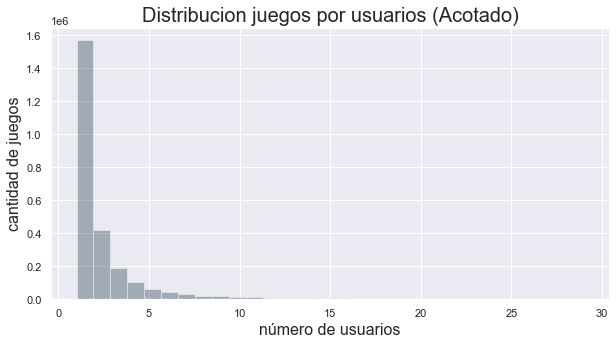

In [14]:
fig = plt.figure(figsize = (10,5))
sns.distplot(user['count'][user['count']<30],kde=False,bins=30)
plt.xlabel("número de usuarios",fontsize=16)
plt.ylabel("cantidad de juegos",fontsize=16)
plt.title('Distribucion juegos por usuarios (Acotado)',fontsize=20)

plt.show()

Como se observa en el gráfico la gran mayoría de los usuarios tienen menos de 5 juegos. Esto puede ser por distintas razones, desde usuarios que solo buscan juegos que únicamente están en la plataforma hasta personas que simplemente quisieron darle una oportunidad a utilizar la plataforma, pero no les intereso. Por esta razón se hace la pregunta ¿Cuantos juegos es necesario que tenga el usuario para que sea relevante en el modelo de recomendación?

* #### product_id ####

In [15]:
games = dr['username'].groupby(dr['product_id']).agg('count').reset_index()
games = games.merge(data_games[['product_id','title']],on='product_id')
games.sort_values(ascending=False,inplace=True,by='username')
games.drop(columns='product_id',axis=1,inplace=True)
games = games[['title','username']]
games.rename(columns={'username':'count'},inplace=True)
print('¿Cuales son los juegos mas populares?')
print(games.head(20))

¿Cuales son los juegos mas populares?
                            title   count
19                Team Fortress 2  121324
2212                         Rust   68031
1003                Borderlands 2   50574
6118                    Fallout 4   48041
3458                    Robocraft   45612
2684           Grand Theft Auto V   41843
6657                    Undertale   40306
1655                         DayZ   39697
1792                     Warframe   38858
22                       Portal 2   38845
1763        Heroes &amp; Generals   35823
3998  Life is Strange - Episode 1   35115
140                   Garry's Mod   33660
4900        ARK: Survival Evolved   30558
8040                         H1Z1   30498
1515                    Starbound   30056
1243                       Arma 3   28868
8365                    Paladins®   28648
255   Sid Meier's Civilization® V   25921
994    Mount &amp; Blade: Warband   25654


In [16]:
print('¿Cuales son los juegos menos populares?')
print(games.tail(20))

¿Cuales son los juegos menos populares?
                                                   title  count
12749                        Bill Hicks: One Night Stand      1
12750                                  Cornflower Corbin      1
14768                                        Banana Town      1
12757            FlatOut 4: Total Insanity Workshop Tool      1
2147                                          Tetrapulse      1
10037         Robotpencil Presents: Female Portrait Demo      1
14079                                              80.08      1
14779                                        Space Chaos      1
12782                                       Lost Village      1
10015                                            Unfazed      1
10009                                              Nerve      1
12776                                             Aokana      1
10006                                 Glengarry GlenRoss      1
12779                                           Cerberus      1


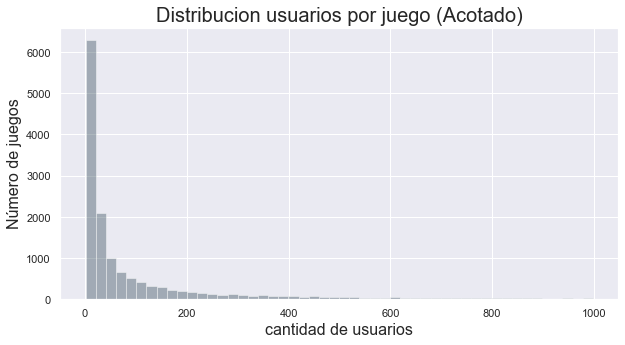

In [17]:
fig = plt.figure(figsize = (10,5))
sns.distplot(games['count'][games['count']<1000],kde=False,bins=50)
plt.ylabel("Número de juegos",fontsize=16)
plt.xlabel("cantidad de usuarios",fontsize=16)
plt.title('Distribucion usuarios por juego (Acotado)',fontsize=20)

plt.show()

Observando el gráfico la mayoría de los juegos no superan los 200 usuarios. Una pregunta que más adelante en el proyecto se responderá es ¿Cuantos usuarios son necesarios para obtener una tendencia en cuanto al sentimiento del juego?

* #### hours ####

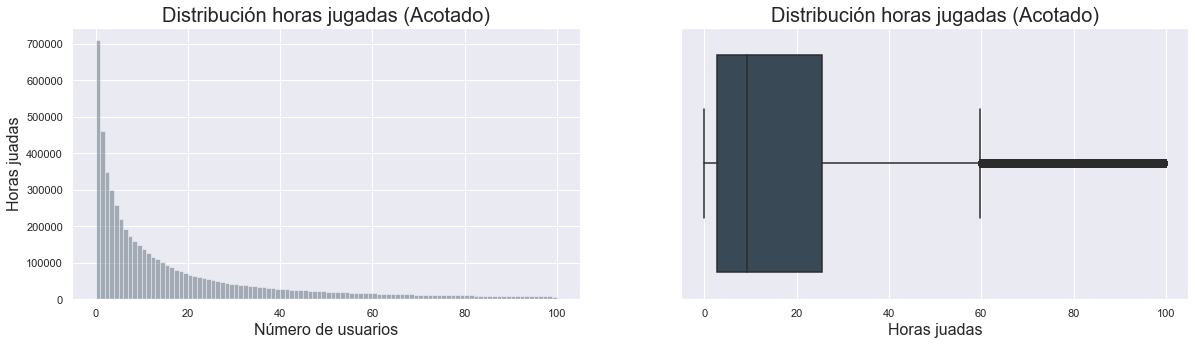

In [18]:
fig = plt.figure(figsize = (10*2,5))

plt.subplot(1,2,1)
sns.distplot(dr['hours'][dr.hours<100],kde=False,bins=100)
plt.ylabel('Horas juadas',fontsize=16)
plt.xlabel('Número de usuarios',fontsize=16)
plt.title('Distribución horas jugadas (Acotado)',fontsize=20)

plt.subplot(1,2,2)
sns.boxplot(dr['hours'][dr.hours<100])
plt.xlabel('Horas juadas',fontsize=16)
plt.title('Distribución horas jugadas (Acotado)',fontsize=20)


plt.show()

Hay una gran cantidad de usuarios que jugaron menos de 1 hora, que se puede considerar un tiempo suficiente para categorizar al usuario como que jugo el juego. 
***
### 2. Consideraciones para el modelo ###

* Se descartarán las reviews con menos de 1hs jugadas, debido a que no se considera un tiempo suficiente para calificar un juego.

In [19]:
ind = dr.hours[dr['hours']<1].index
dr.drop(index=ind,inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀗THE0ERROR󰀗,322330,99.0,Don't Starve Together
1,󰀗THE0ERROR󰀗,204300,138.1,Awesomenauts - the 2D moba
2,󰀗S-Rabbit󰀗,322330,116.0,Don't Starve Together
3,󰀗 Lolicage,244630,7.5,NEOTOKYO
4,󰀖Mr.Tarunio,391540,22.1,Undertale
...,...,...,...,...
6155412,!,386360,6.5,SMITE®
6155413,!,377160,123.3,Fallout 4
6155414,!,304240,42.7,Resident Evil / biohazard HD REMASTER
6155415,!,227940,20.9,Heroes &amp; Generals


* Se descartarán todos los usuarios con menos de 5 reviews, un usuario con menos de 5 reviews puede ensuciar la base de datos.

In [20]:
usu = dr['product_id'].groupby(dr['username']).agg(['count']).reset_index()
dr = pd.merge(dr,usu,on='username')
ind = dr[dr['count']<=5].index
dr.drop(index=ind,inplace=True)
dr.drop(['count'],axis=1,inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀓Oxymoronicphalanx󰀓,378370,8.6,Nomad
1,󰀓Oxymoronicphalanx󰀓,303390,4.3,Dead Bits
2,󰀓Oxymoronicphalanx󰀓,302830,1.9,BLOCKADE 3D
3,󰀓Oxymoronicphalanx󰀓,212800,11.2,Super Crate Box
4,󰀓Oxymoronicphalanx󰀓,200210,346.4,Realm of the Mad God
...,...,...,...,...
2662021,!,386360,6.5,SMITE®
2662022,!,377160,123.3,Fallout 4
2662023,!,304240,42.7,Resident Evil / biohazard HD REMASTER
2662024,!,227940,20.9,Heroes &amp; Generals


* Se descartarán los juegos con menos de 5 reviews, estos juegos no cumplen con la suficiente cantidad de usuarios para ser recomendados.

In [21]:
usu = dr['username'].groupby(dr['product_id']).agg(['count']).reset_index()
dr = pd.merge(dr,usu,on='product_id')
ind = dr[dr['count']<=5].index
dr.drop(index=ind,inplace=True)
dr.drop(['count'],axis=1,inplace=True)
dr.reset_index(drop=True)

,username,product_id,hours,title
0,󰀓Oxymoronicphalanx󰀓,378370,8.6,Nomad
1,😠,378370,81.1,Nomad
2,💜ＫＡＺＡＴＥＲＡ💜,378370,3.1,Nomad
3,🎉,378370,1.3,Nomad
4,𝔂♥𝓱𝓰𝓾𝓻𝓽,378370,11.4,Nomad
...,...,...,...,...
2652014,Greagoir Snow,703870,6.5,Make a word!
2652015,Duustal,703870,6.5,Make a word!
2652016,Brunhowler,703870,1.0,Make a word!
2652017,Brano + Somebod toucha ma spaget,703870,2.0,Make a word!


***

### 3. Modelo de recomendación ###

Se utilizará la librería [Implicit](https://implicit.readthedocs.io/en/latest/), que se especializa en el manejo de Datasets de feedback implicito. El modelo elegido es el de mínimos cuadrados alternantes, este es un modelo de factores latentes, al igual que SVD. Este tipo de modelos tipicamente asocian cada usuario $u$ dentro del conjunto total de usuarios $U$ con un vector factor usuario $x_{u}$ y cada item $i$ dentro del conjunto total de items $I$ con un vector factor item $y_{i}$. 

Los valores de la matriz de interacción son eventos que tienen preferencias y confianza específicas, que dan el valor de cada elemento. Debido a que se está desarrollando un modelo implícito, se introducirá un conjunto de variables binarias, donde será 1 si el usuario jugo el juego más de una hora y 0 para el resto.

$$p_{ui}=\begin{cases} 1& \ hours > 1\\ 0& \ hours < 1 \end{cases}$$

Confianza es la interacción entre el usuario u y el item, escalada en el valor α.

$$c_{ui} = \alpha p_{ui}$$ 

La función de costo del método es la siguiente:

$${min}_{x,y} \sum_{u,i} c_{ui}(p_{ui} - x_{u}^{T}y_{i})^{2} + \lambda \bigg(\sum_{u} \|x_{u}\|^{2} + \sum_{i} \|y_{i}\|^{2}\bigg)$$

Finalmente, el término $\lambda$ se utiliza para regularizar el modelo y su valor se puede determinar mediante validación cruzada.

La minimización de esta función se desarrolla con el método de gradiente conjugado desarrollado en el artículo [Applications of the Conjugate Gradient Method for Implicit Feedback Collaborative Filtering](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.379.6473&rep=rep1&type=pdf).



In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Se crea un codigo nuevo para los usuarios y los items.

In [23]:
le = LabelEncoder()

dr['userid'] = le.fit_transform(dr['username'])
dr['productid'] = le.fit_transform(dr['product_id'])
dr['play'] = 1

In [24]:
import os
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, ranking_metrics_at_k
os.environ['MKL_NUM_THREADS'] = '1'

Se utilizará la librería sparse para crear las matrices de utilidad.

In [25]:
item_user = sparse.csr_matrix((dr['play'].astype(float), (dr['productid'].astype(int), dr['userid'].astype(int))))
user_item = sparse.csr_matrix((dr['play'].astype(float), (dr['userid'].astype(int), dr['product_id'].astype(int))))


Utilizaremos como valor alpha=40, por ser el recomendado, y los hiperparametros del modelo serán los predeterminados.

In [26]:
alpha_val = 40
data_conf = (item_user * alpha_val).astype('double')

train,test = train_test_split(data_conf,train_percentage=0.8)

In [27]:
model = AlternatingLeastSquares()

model.fit(train)

La evaluación del modelo seleccionada se realiza mediante la validación cruzada, entre las predicciones del modelo, entrenada con el conjunto de datos Train, y el conjunto de datos Test para cada usuario.

In [28]:
metrics = ranking_metrics_at_k(model, train.T, test.T, K=20)

print('MAP: ',round(metrics['map'],3))


MAP:  0.042


***
### 4. Modelo de Benchmark ###

Se realizará un modelo de benchmark comparando los TOP 10 items más populares. Para esto se creará una clase que recomiende según el score propuesto según la popularidad de los items.

In [29]:
ranking = dr.productid.value_counts().index
score = np.linspace(10,-10,len(ranking))
recomendations = list(tuple(zip(ranking, score)))

In [30]:
class Benchmark:
    def __init__(self, recomendations):
        self.recomendations = recomendations
        
    def recommend(self, userid, user_item, N):
        recomendations = self.recomendations[:N]
        return recomendations

In [31]:
model_Benchmark = Benchmark(recomendations)

In [32]:
metrics_benchmark = ranking_metrics_at_k(model_Benchmark, train.T, test.T, K=20, show_progress=True)
print('MAP benchmark: ',round(metrics_benchmark['map'],3))


MAP benchmark:  0.027


***
### 5. Optimización de hiperparametros ###



In [34]:
%%time
itera=list(range(5,65,5))
iter_map=[]
for i in itera:
    alpha_val = 40
    data_conf = (item_user * alpha_val).astype('double')
    train, test = train_test_split(data_conf,train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20,regularization=0.1,iterations=i)
    model.fit(train)
    metrics = ranking_metrics_at_k(model, train.T, test.T, K=20)
    iter_map.append(metrics['map'])
    


Wall time: 41min 14s


In [35]:
%%time
regs=list(np.linspace(0.01,1,15,endpoint=True))
regs_map=[]
for i in regs:
    alpha_val = 40
    data_conf = (item_user * alpha_val).astype('double')
    train, test = train_test_split(data_conf,train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20,regularization=i,iterations=15)
    model.fit(train)
    metrics = ranking_metrics_at_k(model, train.T, test.T, K=20)
    regs_map.append(metrics['map'])


Wall time: 23min 58s


In [36]:
%%time
facts=list(range(5,65,5))
facts_map=[]
for i in facts:
    alpha_val = 40
    data_conf = (item_user * alpha_val).astype('double')

    train, test = train_test_split(data_conf,train_percentage=0.8)
    model = AlternatingLeastSquares(factors=i,regularization=0.1,iterations=15)
    model.fit(train)
    metrics = ranking_metrics_at_k(model, train.T, test.T, K=20)
    facts_map.append(metrics['map'])


Wall time: 52min 10s


In [37]:
%%time
alpha=list(range(5,65,5))
alpha_map=[]
for i in alpha:
    alpha_val = i
    data_conf = (item_user * alpha_val).astype('double')
    train, test = train_test_split(data_conf,train_percentage=0.8)
    model = AlternatingLeastSquares(factors=20,regularization=0.1,iterations=15)
    model.fit(train)
    metrics = ranking_metrics_at_k(model, train.T, test.T, K=20)
    alpha_map.append(metrics['map'])


Wall time: 1h 23min 47s


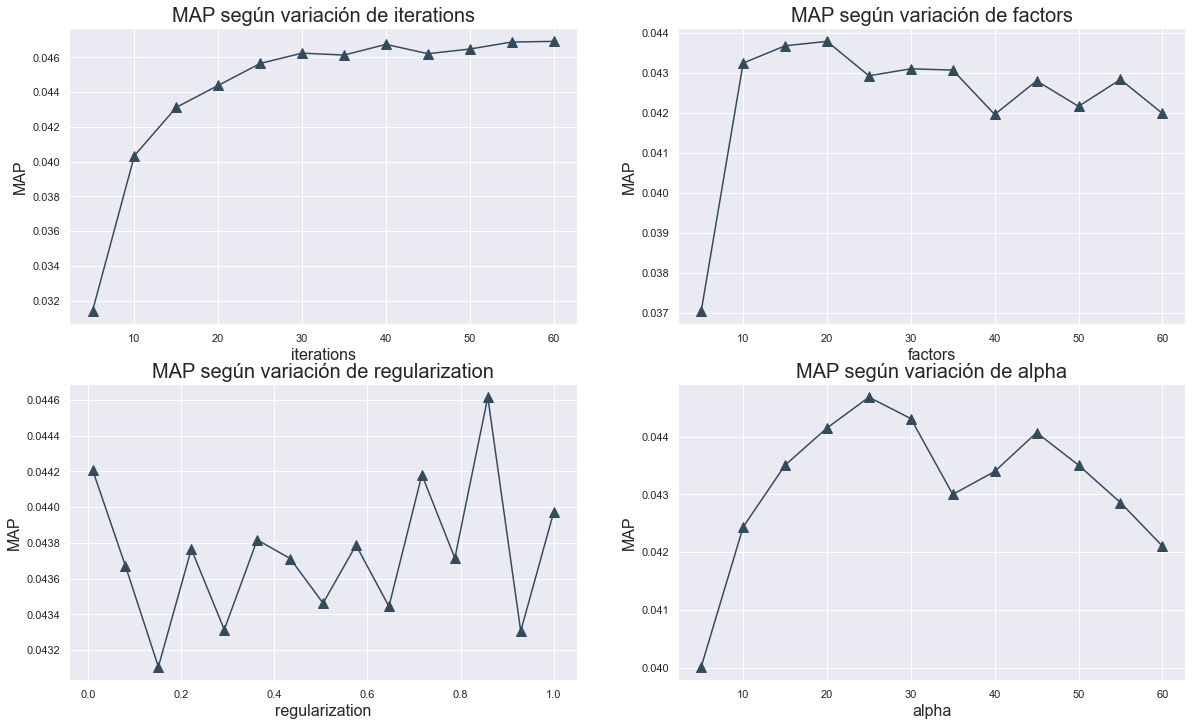

In [38]:
fig = plt.figure(figsize = (10*2,6*2))

plt.subplot(2,2,1)
plt.plot(itera,iter_map,marker='^',markersize=10)
plt.xlabel('iterations',fontsize=16)
plt.ylabel('MAP',fontsize=16)
plt.title('MAP según variación de iterations',fontsize=20)

plt.subplot(2,2,2)
plt.plot(facts,facts_map,marker='^',markersize=10)
plt.xlabel('factors',fontsize=16)
plt.ylabel('MAP',fontsize=16)
plt.title('MAP según variación de factors',fontsize=20)

plt.subplot(2,2,3)
plt.plot(regs,regs_map,marker='^',markersize=10)
plt.xlabel('regularization',fontsize=16)
plt.ylabel('MAP',fontsize=16)
plt.title('MAP según variación de regularization',fontsize=20)
               
plt.subplot(2,2,4)
plt.plot(alpha,alpha_map,marker='^',markersize=10)
plt.xlabel('alpha',fontsize=16)
plt.ylabel('MAP',fontsize=16)
plt.title('MAP según variación de alpha',fontsize=20)

plt.show()

A partir de estos resultados se acotarán las posibilidades de los hiperparametros y se realizara un ciclo probando todas las opciones posibles para obtener el mayor valor de la métrica. 

En cuanto a los hiperparametros se definió:
* Las `iteraciones`, como se observa en el gráfico, a partir de cierto valor tiende a mantenerse constante por lo que se definió que se mantendrá constante en el valor 40.
* los `factores` a partir de cierto valor tiene una tendencia decreciente por lo que se mantendrá en el mayor valor que es 20.
* El valor `alpha` parece que tiene una tendencia decreciente a mayores valores por lo que se acotara entre 20 y 40 con un paso de 2.
* La `regularizacion` es la variable más irregular por lo que se mantendrá las opciones que se evaluaron anteriormente.

In [39]:
%%time
alpha = list(range(20,40,4))
regs = list(np.linspace(0.01,1,5,endpoint=True))
MAP = []

ALPHA = []
REGS = []
for i in alpha:
    for j in regs:
        alpha_val = i
        data_conf = (item_user * alpha_val).astype('double')
        train, test = train_test_split(data_conf,train_percentage=0.8)
        model = AlternatingLeastSquares(factors=20,regularization=j,iterations=40)
        model.fit(train)
        metrics = ranking_metrics_at_k(model, train.T, test.T, K=20)
        
        MAP.append(metrics['map'])
        ALPHA.append(i)
        REGS.append(j)
        
grid = {'alpha':ALPHA,'regularizacion':REGS,'MAP':MAP}

grid_search = pd.DataFrame(data=grid)





Wall time: 53min


In [40]:
grid_search[grid_search['MAP']==grid_search['MAP'].max()]

,alpha,regularizacion,MAP
13,28,0.7525,0.047122


Los hiperparametros definidos son:
* `alpha` = 28
* `factors`= 20
* `regularization` = 0.7525
* `iterations` = 40

In [41]:
alpha_val = 28
data_conf = (item_user * alpha_val).astype('double')
train, test = train_test_split(data_conf,train_percentage=0.8)
model = AlternatingLeastSquares(factors=20,regularization=0.7525,iterations=40)
model.fit(train)

A continuación, se evaluará la métrica según la cantidad de predicciones.

In [42]:
%%time
k = list(range(5,305,20))
k_map = []
k_map_bench = []

for i in k:
    metrics = ranking_metrics_at_k(model, train.T, test.T, K=i)
    metrics_bench = ranking_metrics_at_k(model_Benchmark, train.T, test.T, K=i)
    k_map.append(metrics['map'])
    k_map_bench.append(metrics_bench['map'])
    


Wall time: 25min 54s


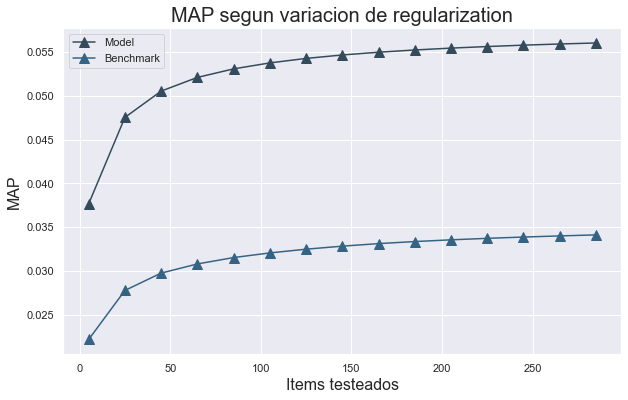

In [43]:
fig = plt.figure(figsize = (10,6))

plt.plot(k,k_map,marker='^',markersize=10)
plt.plot(k,k_map_bench,marker='^',markersize=10)
plt.xlabel('Items testeados',fontsize=16)
plt.ylabel('MAP',fontsize=16)
plt.title('MAP segun variacion de regularization',fontsize=20)
plt.legend(['Model','Benchmark'])

plt.show()

Como se observa en el grafico a medida que se incrementa el número de items testeados la métrica aumenta progresivamente, tanto para el modelo como par el modelo de benchmark.
***
### 6. Predicciones a un usuario aleatorio ###

A partir de un usuario aleatorio y del modelo entrenado, se buscan las recomendaciones, la similitud entre items y usuarios. A partir del top recomendaciones y la similitud de los items, se puede esperar que los items más similares estén en la lista de items del usuario. Al mismo tiempo se puede esperar que los usuarios más similares compartan ciertos items.

In [33]:
user = 93214
user_name = dr['username'][dr.userid==user].to_list()[0]
list_games = dr['title'][dr.userid==user].to_list()
list_games.sort()
list_games_codes = dr['productid'][dr.userid==user].to_list()

In [34]:
print('Usuario:',user_name)
print('N° de juegos: ', len(list_games))
print('Juegos: ',list_games)

Usuario: Omae wa mou shindeiru
N° de juegos:  74
Juegos:  ['Ace of Spades: Battle Builder', 'AdVenture Capitalist', 'Alien Swarm: Reactive Drop', 'Alien: Isolation', 'Amnesia: The Dark Descent', "Assassin's Creed 2 Deluxe Edition", 'Azure Striker Gunvolt', 'BattleBlock Theater®', 'Blood and Bacon', 'Brawlhalla', 'Call of Juarez® Gunslinger', 'Chivalry: Medieval Warfare', 'Clicker Heroes', 'Counter-Strike: Source', 'Crypt of the NecroDancer', 'DC Universe™ Online', 'DRAGON BALL XENOVERSE', 'Dead Space', 'Dead Space™ 2', 'Deceit', 'Defiance', 'Dino D-Day', 'Disney Princess: My Fairytale Adventure', 'Dungeon Defenders', 'Dungeon Defenders II', 'Dying Light', 'Fallout 4', "Five Nights at Freddy's 2", 'Grand Theft Auto: San Andreas', 'H1Z1', 'Half-Life 2', 'Hero Siege', 'Hitman: Absolution™', 'Hollow Knight', 'Hyperdimension Neptunia Re;Birth1 / 超次次元ゲイム ネプテューヌRe;Birth1 / 超次次元遊戲戰機少女重生1', 'Insanity Clicker', 'L.A. Noire', 'LEGO® Star Wars™ - The Complete Saga', 'LEGO® The Hobbit™', 'Middle-ea

In [35]:
recomendacion=model.recommend(userid=user, user_items=user_item, N=20, filter_items=list_games_codes)

In [36]:
games = []
scores = []
print('Recomendaciones para el usuario: \n')
for i in range(len(recomendacion)):
    game = dr['title'][dr.productid==recomendacion[i][0]].to_list()[0]
    score = recomendacion[i][1]
    
    games.append(game)
    scores.append(score)
    
recom = pd.Series(scores,games)
print(recom)

Recomendaciones para el usuario: 

Contagion                                                1.577044
Starbound                                                1.531107
Call of Duty®: Modern Warfare® 2                         1.347129
Borderlands 2                                            1.338937
Surgeon Simulator                                        1.296009
Who's Your Daddy                                         1.277303
Nether: Resurrected                                      1.264806
Warface                                                  1.254567
Battlefield: Bad Company™ 2                              1.235928
Call of Duty® 4: Modern Warfare®                         1.216237
Resident Evil Revelations 2 / Biohazard Revelations 2    1.208945
Friday the 13th: The Game                                1.186933
Sniper Elite V2                                          1.185295
Just Cause 2: Multiplayer Mod                            1.173524
Batman™: Arkham Knight                   

Se busca los items similares a la recomendación número 1.

In [37]:
top_item = recomendacion[0][0]

similar = model.similar_items(itemid=top_item,N=15)

In [38]:
games = []
scores = []
print('Juegos similares a la recomendación N°1: \n')
for i in range(len(similar)):
    game = dr['title'][dr.productid==similar[i][0]].to_list()[0]
    score = similar[i][1]
    
    games.append(game)
    scores.append(score)
    
recom = pd.Series(scores,games)
print(recom)

Juegos similares a la recomendación N°1: 

Contagion                                                 1.000000
Zombie Panic! Source                                      0.473897
Nether: Resurrected                                       0.468858
Damned                                                    0.460050
Tom Clancy's Ghost Recon: Future Soldier™                 0.457842
Ylands                                                    0.448819
Dead Rising® 2                                            0.442652
Survival: Postapocalypse Now                              0.430685
Stigmat                                                   0.428397
Stationeers                                               0.427453
Dead Sky                                                  0.425570
Zombie Grinder                                            0.424782
Linea, the Game                                           0.423572
Estranged: Act I                                          0.422660
Magic: The Gatherin

In [39]:
cont = 0
sim_games=[]
for i in games:
    if i in list_games:
        cont+=1
        sim_games.append(i)
        
print('Número de juegos similares a la recomendación N°1 que tiene el usuario: ',cont)
print('Juegos: ',sim_games)

Número de juegos similares a la recomendación N°1 que tiene el usuario:  1
Juegos:  ["Tom Clancy's Ghost Recon: Future Soldier™"]


Como se esperaba los items con mayor similitud a la primera recomendación se encuentran en la lista del usuario.

In [40]:
sim_user = model.similar_users(userid=user,N=10)

users = []
scores = []
print('Usuarios similares a ',user_name,': \n')
for i in range(len(sim_user)):
    use = dr['username'][dr.userid==sim_user[i][0]].to_list()[0]
    score = sim_user[i][1]
    
    users.append(use)
    scores.append(score)
    
recom = pd.Series(scores,users)
print(recom)

Usuarios similares a  Omae wa mou shindeiru : 

Omae wa mou shindeiru    1.000000
Anonymous                0.663655
Apple                    0.641218
Logan Paul               0.640991
LilAutismKid             0.640245
❤ Jack ❤                 0.631735
Kappa                    0.626433
Turtle                   0.625896
SANIC                    0.623513
Lemur                    0.621569
dtype: float64


In [41]:
top_user=sim_user[1][0]
top_user_name = dr['username'][dr.userid==top_user].to_list()[0]
top_list_games = dr['title'][dr.userid==top_user].to_list()


cont = 0
sim_games=[]

for i in top_list_games:
    if i in list_games:
        cont+=1
        sim_games.append(i)
        
print('Número de juegos compartidos con el usuario mas similar: ',cont)
print('Juegos: ',sim_games)

Número de juegos compartidos con el usuario mas similar:  31
Juegos:  ['The Binding of Isaac', 'Rust', 'Dungeon Defenders', "Five Nights at Freddy's 2", 'Thief', 'Saints Row: The Third', 'Team Fortress 2', 'Half-Life 2', 'No More Room in Hell', 'Project Zomboid', 'Trove', 'Chivalry: Medieval Warfare', 'Undertale', 'Mortal Kombat X', 'Warframe', 'Call of Juarez® Gunslinger', 'Paladins®', 'H1Z1', 'Clicker Heroes', 'Dying Light', 'BattleBlock Theater®', 'Counter-Strike: Source', 'Fallout 4', 'Alien: Isolation', 'Grand Theft Auto: San Andreas', 'Dungeon Defenders II', 'Brawlhalla', 'Risk of Rain', 'Hero Siege', 'Ace of Spades: Battle Builder', 'Rivals of Aether']


La similitud de usuarios se puede observar en la gran cantidad de items que comparten.

***
### 7. Conclusión ###

Luego de una profunda exploración de datos y utilizando la librería Implicit se logró obtener un modelo de recomendación para la base de datos de Steam. Si bien se llegó al objetivo del proyecto hay varias cuestiones que podrían mejorar este modelo. El usuario seleccionado para el ejemplo tiene una gran cantidad de items, los buenos resultados del modelo pueden ser circunstanciales debido a la cantidad de items del usuario. Un usuario con menor cantidad de items puede tener resultados menos precisos. 

* Consideraciones más estrictas en los criterios que se definieron los filtros para la base de datos. Por ejemplo, considerar que se necesitan más de 5 horas para considerar que el usuario puede calificar el juego. Esto daría probablemente una base de datos más completa y eso ayudaría al modelo. 

* Filtrar los juegos según sus tags y realizar un modelo para cada categoría puede tener mejor precisión al momento de recomendar.

* Hay una columna que no se utilizó en el modelo que es `sentiment` en la base de datos `data_games`, estos datos son una clasificación que nos da Steam obtenido de las reviews de los usuarios, esta columna podría servir al modelo para facilitar la recomendación.

* Un tema que se dijo anteriormente es la aplicación de procesamiento de lenguaje natural en la columna de `text` de `data_reviews` para poder calificar verdaderamente la opinión del usuario al juego.
